In [ ]:
import re
import numpy as np
import pandas as pd

import time
import string
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

from snowballstemmer import stemmer

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV

import seaborn as sns


In [ ]:
nltk.download('stopwords')

In [ ]:
punctuations_list = string.punctuation

def cleaning_txt(data):
    data = re.sub(r'@\S+', '', data)
    data = re.sub(r'#','',data)
    return data

def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)

def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)

def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)

def split_stacked_words(data):
    if not isinstance(data, str):
        return data
    pattern = re.compile(r'([α-ωά-ώ])([Α-ΩΆ-Ώ])', re.UNICODE)
    data = re.sub(pattern, r'\1 \2', data)  #Add a space
    return data

def remove_greek_numerals(data):
    # Define a regular expression pattern to match Greek numerals
    greek_numeral_pattern = re.compile(r'\b(?:Ένα|Δύο|Τρία|Τέσσερα|Πέντε|Έξι|Επτά|Οκτώ|Εννέα|Δέκα|Έντεκα|Δώδεκα|Δεκατρία|Δεκατέσσερα|Δεκαπέντε|Δεκαέξι|Δεκαεπτά|Δεκαοκτώ|Δεκαεννέα|Είκοσι|Τριάντα|Σαράντα|Πενήντα|Εξήντα|Εβδομήντα|Ογδοήντα|Ενενήντα|Εκατό|Χίλια|ένα|δύο|τρία|τέσσερα|πέντε|έξι|επτά|οκτώ|εννέα|δέκα|έντεκα|δώδεκα|δεκατρία|δεκατέσσερα|δεκαπέντε|δεκαέξι|δεκαεπτά|δεκαοκτώ|δεκαεννέα|είκοσι|τριάντα|σαράντα|πενήντα|εξήντα|εβδομήντα|ογδοήντα|ενενήντα|εκατό|χίλια)\b', re.UNICODE)
    # Replace matched Greek numerals with an empty string
    cleaned_text = re.sub(greek_numeral_pattern, '', data)
    return cleaned_text

def remove_single_letter_words(data):
    single_letter_word_pattern = re.compile(r'\b\w\b')
    # Replace matched single-letter words with an empty string
    cleaned_text = re.sub(single_letter_word_pattern, '', data)
    return cleaned_text



In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:

nltk.download('punkt')
nltk.download('wordnet')



In [ ]:
DATASET_COLUMNS=['ids','text','target','party']
# DATASET_ENCODING = "ISO-8859-1"
DATASET_ENCODING = "UTF-8"
df = pd.read_csv('train_set.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df2 = pd.read_csv('valid_set.csv',encoding=DATASET_ENCODING,names=DATASET_COLUMNS)
df = pd.concat([df, df2.iloc[1:]], ignore_index=True)


------------ Creating a new CSV file ----------------

 ------------ New CSV Created ----------------- 


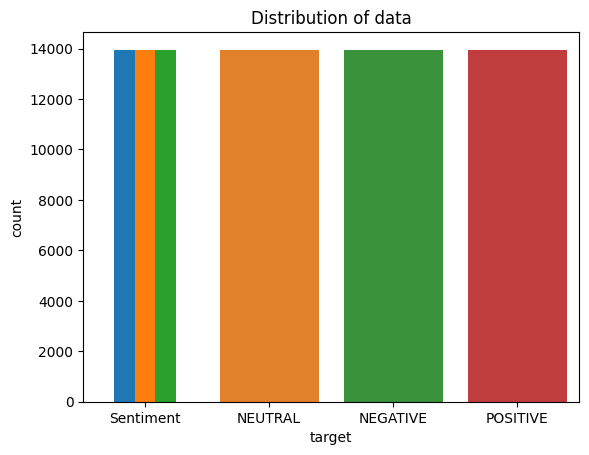

In [ ]:
print("\n------------ Creating a new CSV file ----------------\n")

# Plotting the distribution for dataset.
ax = df.groupby('target').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Sentiment','NEUTRAL','NEGATIVE','POSITIVE'], rotation=0)
# Storing data in lists.

sns.countplot(x='target', data=df)

# select text and target column
df = df[['ids','text','target']]

greek_stopwords = set(stopwords.words('greek'))
greek_stemmer = stemmer("greek")

df['text'] = df['text'].apply(lambda x: cleaning_txt(x))
df['text'] = df['text'].apply(lambda x: cleaning_repeating_char(x))
df['text'] = df['text'].apply(lambda x: cleaning_URLs(x))
df['text']= df['text'].apply(lambda x: cleaning_punctuations(x))
df['text'] = df['text'].apply(lambda x: cleaning_numbers(x))
df['text'] = df['text'].apply(lambda x: split_stacked_words(x))
df['text'] = df['text'].apply(lambda x: remove_greek_numerals(x))
df['text'] = df['text'].apply(lambda x: remove_single_letter_words(x))

lemmatizer = WordNetLemmatizer()

for i in range(1,len(df)-1):
    text = df['text'].iloc[i]
    tokenized_txt = word_tokenize(text)

    without_stpwords_words = [word for word in tokenized_txt if word.lower() not in greek_stopwords]
    without_stpwords_txt = ' '.join(without_stpwords_words)

    # stemmed_words = [greek_stemmer.stemWord(word) for word in tokenized_txt]
    # stemmed_txt = ' '.join(stemmed_words)

    lemmatized_words = [lemmatizer.lemmatize(word, pos='v') for word in without_stpwords_txt]  # 'v' indicates the part of speech (verb)
    lemmatized_txt = ' '.join(lemmatized_words)

    df.at[i,'text'] = without_stpwords_txt

df.to_csv("train_set_new.csv",index=False,encoding=DATASET_ENCODING)

print(" ------------ New CSV Created ----------------- ")

In [ ]:
print("\n------------ Starting editing the new CSV ----------------\n")

DATASET_COLUMNS = ['ids','text','target']
df = pd.read_csv('train_set_new.csv', encoding=DATASET_ENCODING)
df = df.iloc[1:]
df.fillna("", inplace=True)

# Separating input feauture and label
X=df.text
y=df.target

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.15, random_state =26105111)

vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

def model_Evaluate(model):
# # Predict values for Test dataset
    y_pred = model.predict(X_test)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive','Neutral']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    sns.heatmap(cf_matrix, annot = True, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

print("\n------------ LogisticRegression Model ----------------\n")


# # LogisticRegression Model
LRmodel = LogisticRegression(max_iter = 1000, n_jobs=-1)



------------ Starting editing the new CSV ----------------

No. of feature_words:  369079

------------ LogisticRegression Model ----------------



In [ ]:
print("\n------------ Hyperparameters ----------------\n")

param_grid = {'C': [0.01, 0.1, 1, 10],}
grid_search = GridSearchCV(estimator=LRmodel, param_grid=param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
# Fit the model to the training data
grid_search.fit(X_train, y_train)
print("Best Hyperparameters:", grid_search.best_params_)
# Get the best model
best_LRmodel = grid_search.best_estimator_
# Evaluate the model with the best hyperparameters
model_Evaluate(best_LRmodel)
print("\n ------------- Hyperparameters DONE ------------- \n")

In [ ]:
best_LRmodel.fit(X_train, y_train)
y_pred3 = best_LRmodel.predict(X_test)

In [ ]:
DATASET_COLUMNS=['ids','text','party']
DATASET_ENCODING = "UTF-8"
test_df = pd.read_csv('test_set.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
test_df = test_df[1:]
X_test_new = vectoriser.transform(test_df.text)
test_predictions = best_LRmodel.predict(X_test_new)

# Create a new DataFrame with 'id' and 'prediction' columns
result_df = pd.DataFrame({'Id': test_df.ids, 'Predicted': test_predictions})

# Save the result to a new CSV file
result_df.to_csv('submission.csv', index=False)
print(" -------------------------- New CSV edited and submission created ----------------- ")

 -------------------------- New CSV edited and submission created ----------------- 


In [ ]:
print("\n ------------- Learning Curves 1st way ------------- \n")


# ####### unfinished try for a faster Learning Curve ##############



print("# ######### unfinished try for a faster Learning Curve ##############")


# from sklearn.metrics import f1_score

# list_f1=[]
# list_f1_train=[]
# list_sample_size=[]

# for times in range(10):
#   # training
#   #
#   x, x_unused, Y, Y_unused = train_test_split(X_train, y_train, test_size=1 - (times * 0.1 + 0.001))

#   classifier = LogisticRegression(max_iter=2000)
#   classifier.fit(x, np.ravel(Y))

#   results_train = classifier.predict(x)

#   # validation
#   #
#   results = classifier.predict(X_test)

#   # score
#   #
#   f1_train = f1_score(Y, results_train, average='weighted')
#   print("F1 Score Train: " + str(f1_train))

#   f1 = f1_score(y_test, results, average='weighted')
#   print("F1 Score Validation: " + str(f1))

#   list_f1.append(f1)
#   list_f1_train.append(f1_train)
#   list_sample_size.append((times * 0.1 + 0.1))

# plt.plot(list_sample_size, list_f1)
# plt.plot(list_sample_size, list_f1_train)

# plt.ylim(ymin=0)
# plt.legend(["Validation", "Training"])

print("\n ------------- DONE ------------- \n")


 ------------- Learning Curves 1st way ------------- 

# ######### unfinished try for a faster Learning Curve ##############

 ------------- DONE ------------- 



In [ ]:
print("\n ------------- Learning Curves 2nd way ------------- \n")
# Set up cross-validation with 2 splits
cv = ShuffleSplit(n_splits=2, test_size=0.15, random_state=42352)

# Generate learning curve data
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(LRmodel, X_train, y_train, cv=cv, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10),return_times=True)

# Calculate mean and standard deviation of training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Learning Curve for Logistic Regression")
plt.legend(loc="best")
plt.show()

print("\n ------------- DONE ------------- \n")
